In [66]:
from __future__ import division #NOTE: this prevent errors warning GPU0 <> GPU1 (GPU1 has < 75% capacity of GPU0)
import numpy as np
import pickle
import cv2
import imp

import torch as t
import torchvision as tv
import torchvision.transforms as transform
#from torch.utils.data import Dataset, DataLoader

import header_headoren_salcorr as header
import header_saliency_ds as header_sal
imp.reload(header_sal)
imp.reload(header)

from matplotlib import pyplot as plt
%matplotlib inline

use_cuda = t.cuda.is_available()
device = t.device("cuda:1" if use_cuda else "cpu")

H_SAL = 90
W_SAL = 160

del H_SAL
del W_SAL

def modify_fc_layers_obsoleted(model):
    #TODO: change default resnet: avgpool (3, 3), fc (2048 x 3 x 3) --> 90x160
    model.avgpool = t.nn.AdaptiveAvgPool2d(3)
    model.fc = t.nn.Linear(3 * 3 * 2048, H_SAL*W_SAL) # assuming that the fc7 layer has 512 neurons, otherwise change it 
    
def modify_fc_layers(model):
    model.avgpool = t.nn.AdaptiveAvgPool2d(3)
    model.fc = t.nn.Linear(3 * 3 * 2048, header_sal.TARGET_SAL_H*header_sal.TARGET_SAL_W) # assuming that the fc7 layer has 512 neurons, otherwise change it 
    
    
class PanoSalDataset(t.utils.data.Dataset):
    def __init__(self, pickle_file, transform=None):
        self._pickle_file = pickle_file
        self._dat = pickle.load(open(pickle_file, 'rb'))
    
    def __len__(self):
        return len(self._dat)
    
    def __getitem__(self, idx):
        if t.is_tensor(idx):
            idx = idx.tolist()
        t0, img, smap = self._dat[idx]
        #print (f'Before: {img.shape}')
        img = img.transpose((2, 0, 1))
        #print (f'After: {img.shape}')
        return t0, img, smap
    

In [2]:
#NOTE: this step is only done ONCE to convert pretrained saliency 144x256 to saliency 45x80
#after the converion, the model will be save, this code will be commented out
# PATH = './models/panoresnet152_step002_891'
# resnet = tv.models.resnet152(pretrained=True)
# modify_fc_layers(resnet)
# resnet.load_state_dict(t.load(PATH, map_location=device))
# modify_fc_layers_v2(resnet)
# t.save(resnet.state_dict(), './models/panoresnet152_sal45x80_step002_epoch0')


In [3]:
PATH = './models/panoresnet152_sal45x80_step002_epoch0'
resnet = tv.models.resnet152(pretrained=True)
modify_fc_layers(resnet)
resnet.to(device)
resnet.load_state_dict(t.load(PATH, map_location=device))

<All keys matched successfully>

In [4]:
sal_ds_filepath = './data/pano-saliency/ds_dcnn_step0.2'
#sal_ds_filepath = './dataset/pano-saliency/ds_full'
tf5 =  transform.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
transformed_dataset = PanoSalDataset(sal_ds_filepath, transform=tv.transforms.Compose([tv.transforms.ToTensor(), tf5]))
trainloader = t.utils.data.DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=4)


In [5]:
resnet.avgpool, resnet.fc

(AdaptiveAvgPool2d(output_size=3),
 Linear(in_features=18432, out_features=3600, bias=True))

In [6]:
learning_rate = 3e-4
optim = t.optim.Adam(resnet.parameters(), lr=learning_rate, weight_decay=1e-6)
loss_log = []

In [ ]:
def get_lr(optimizer):#directly change learning rate of the optimizer
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
import timeit

N_EPOCH = 900
N_REPORT = 200


btime = timeit.default_timer()
for epoch in range(N_EPOCH):
    running_loss = 0.
    for i, (t0, img_list, label_list) in enumerate(trainloader):
        start = t.cuda.Event(enable_timing=True)
        end = t.cuda.Event(enable_timing=True)
        start.record() ###measure training time for one iteration
        img_list = img_list.type(t.FloatTensor).to(device)
        label_list = label_list.type(t.FloatTensor).to(device)
        optim.zero_grad()
        fx = resnet(img_list)
        #print (fx.shape)
        fx = fx.view(-1, header_sal.TARGET_SAL_H, header_sal.TARGET_SAL_W)
        #loss = t.nn.functional.mse_loss(fx, label_list)
        loss = t.norm(fx - label_list, 2)
        loss.backward()#now backward, grad in graph will have something
        optim.step()#now, the weights is update.
        
        running_loss += loss.item()
        if i % N_REPORT == N_REPORT-1:    # print every N_REPORT mini-batches
            end.record()
            t.cuda.synchronize()
            
            print ('iter time: {}, exec time: {}, cur learning rate: {}'.format(start.elapsed_time(end), timeit.default_timer() - btime, get_lr(optim)))
            btime = timeit.default_timer()
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / N_REPORT))
            loss_log.append(running_loss/N_REPORT)
            running_loss = 0.0
            
            
    #eval_accuracy(yolo, pred, testloader, device, threshold=0.5)
    if epoch % 30 ==0 and epoch > 1:
                t.save(resnet.state_dict(), './models/panoresnet152_sal45x80_step002_{}'.format(epoch))
                #eval_accuracy(yolo, pred, testloader, device, threshold=0.5)

iter time: 115.35052490234375, exec time: 25.69706818088889, cur learning rate: 0.0003
[1,   200] loss: 4.775
iter time: 116.87443542480469, exec time: 23.53536731330678, cur learning rate: 0.0003
[1,   400] loss: 3.515
iter time: 117.05241394042969, exec time: 23.566864364780486, cur learning rate: 0.0003
[1,   600] loss: 2.967
iter time: 115.76831817626953, exec time: 23.43493709806353, cur learning rate: 0.0003
[1,   800] loss: 2.588
iter time: 115.83606719970703, exec time: 23.42250117007643, cur learning rate: 0.0003
[1,  1000] loss: 2.549
iter time: 115.97516632080078, exec time: 23.729177265893668, cur learning rate: 0.0003
[1,  1200] loss: 2.413
iter time: 116.5024642944336, exec time: 23.556186594069004, cur learning rate: 0.0003
[1,  1400] loss: 2.258
iter time: 124.12825775146484, exec time: 38.149049752857536, cur learning rate: 0.0003
[2,   200] loss: 1.989
iter time: 116.10623931884766, exec time: 24.686959547922015, cur learning rate: 0.0003
[2,   400] loss: 1.921
iter t

iter time: 125.54537963867188, exec time: 24.816373966168612, cur learning rate: 0.0003
[11,  1200] loss: 1.027
iter time: 126.36284637451172, exec time: 25.594557399861515, cur learning rate: 0.0003
[11,  1400] loss: 1.008
iter time: 117.40467071533203, exec time: 38.02934425184503, cur learning rate: 0.0003
[12,   200] loss: 0.879
iter time: 116.96752166748047, exec time: 23.695258665829897, cur learning rate: 0.0003
[12,   400] loss: 0.930
iter time: 117.03398132324219, exec time: 23.577937555965036, cur learning rate: 0.0003
[12,   600] loss: 0.938
iter time: 116.55270385742188, exec time: 23.630802385043353, cur learning rate: 0.0003
[12,   800] loss: 0.962
iter time: 125.82911682128906, exec time: 24.223525885958225, cur learning rate: 0.0003
[12,  1000] loss: 0.978
iter time: 123.9881591796875, exec time: 25.53713996708393, cur learning rate: 0.0003
[12,  1200] loss: 0.952
iter time: 126.9552993774414, exec time: 25.668869756162167, cur learning rate: 0.0003
[12,  1400] loss: 0.

iter time: 122.21110534667969, exec time: 25.454769854899496, cur learning rate: 0.0003
[22,   600] loss: 0.842
iter time: 129.148193359375, exec time: 25.52762033417821, cur learning rate: 0.0003
[22,   800] loss: 0.851
iter time: 123.36131286621094, exec time: 25.414681527297944, cur learning rate: 0.0003
[22,  1000] loss: 0.834
iter time: 138.06704711914062, exec time: 25.44748999737203, cur learning rate: 0.0003
[22,  1200] loss: 0.839
iter time: 130.96316528320312, exec time: 25.396614209283143, cur learning rate: 0.0003
[22,  1400] loss: 0.849
iter time: 118.20748901367188, exec time: 38.42249865364283, cur learning rate: 0.0003
[23,   200] loss: 0.779
iter time: 127.24944305419922, exec time: 25.603389562573284, cur learning rate: 0.0003
[23,   400] loss: 0.793
iter time: 119.67488098144531, exec time: 25.679178145714104, cur learning rate: 0.0003
[23,   600] loss: 0.818
iter time: 127.22892761230469, exec time: 25.476901797112077, cur learning rate: 0.0003
[23,   800] loss: 0.8

iter time: 131.8594512939453, exec time: 25.465217408258468, cur learning rate: 0.0003
[32,  1400] loss: 0.718
iter time: 118.43174743652344, exec time: 36.962544647976756, cur learning rate: 0.0003
[33,   200] loss: 0.653
iter time: 116.35718536376953, exec time: 23.65128923393786, cur learning rate: 0.0003
[33,   400] loss: 0.706
iter time: 116.60304260253906, exec time: 23.641984376125038, cur learning rate: 0.0003
[33,   600] loss: 0.680
iter time: 116.37964630126953, exec time: 23.613779531791806, cur learning rate: 0.0003
[33,   800] loss: 0.705
iter time: 116.52710723876953, exec time: 23.624089498072863, cur learning rate: 0.0003
[33,  1000] loss: 0.715
iter time: 116.38761901855469, exec time: 23.605481582228094, cur learning rate: 0.0003
[33,  1200] loss: 0.698
iter time: 135.78956604003906, exec time: 24.331332531757653, cur learning rate: 0.0003
[33,  1400] loss: 0.725
iter time: 131.71536254882812, exec time: 38.35522327525541, cur learning rate: 0.0003
[34,   200] loss: 0

iter time: 116.3763198852539, exec time: 23.65765673900023, cur learning rate: 0.0003
[43,   800] loss: 0.673
iter time: 116.34819030761719, exec time: 23.6660149670206, cur learning rate: 0.0003
[43,  1000] loss: 0.664
iter time: 116.43904113769531, exec time: 23.638502602931112, cur learning rate: 0.0003
[43,  1200] loss: 0.685
iter time: 127.87407684326172, exec time: 25.30791627895087, cur learning rate: 0.0003
[43,  1400] loss: 0.686
iter time: 127.98159790039062, exec time: 38.59100061003119, cur learning rate: 0.0003
[44,   200] loss: 0.634
iter time: 123.7391357421875, exec time: 25.5023927167058, cur learning rate: 0.0003
[44,   400] loss: 0.617
iter time: 128.012451171875, exec time: 25.545973651576787, cur learning rate: 0.0003
[44,   600] loss: 0.630
iter time: 123.93580627441406, exec time: 25.60816078307107, cur learning rate: 0.0003
[44,   800] loss: 0.617
iter time: 118.19827270507812, exec time: 25.637834135908633, cur learning rate: 0.0003
[44,  1000] loss: 0.659
iter

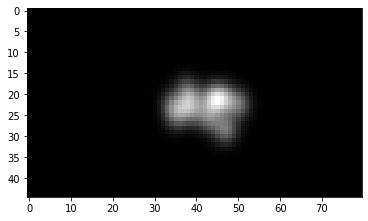

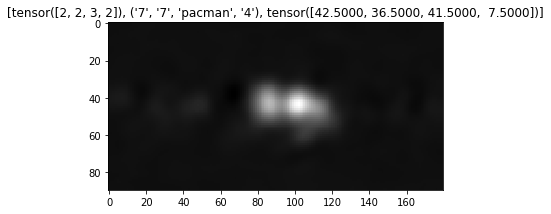

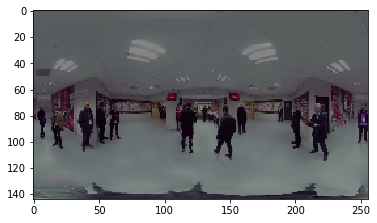

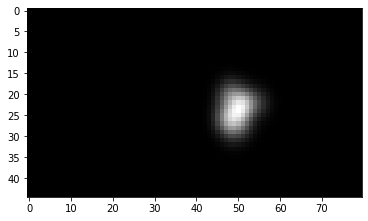

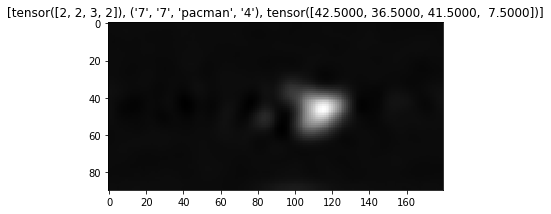

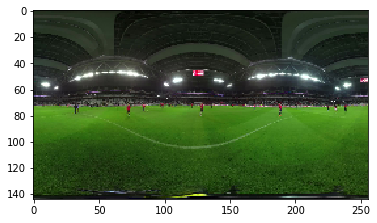

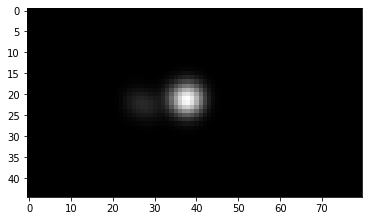

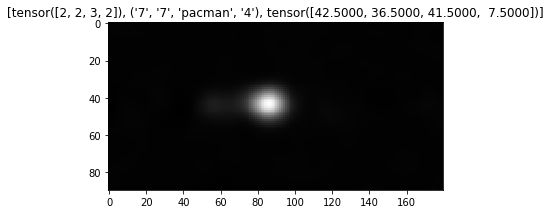

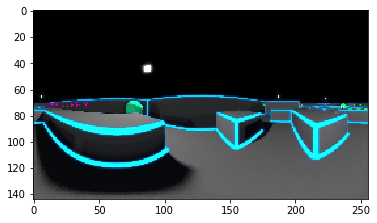

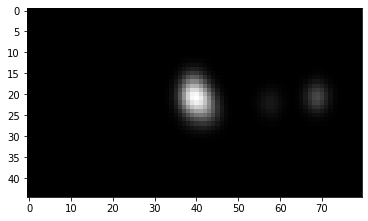

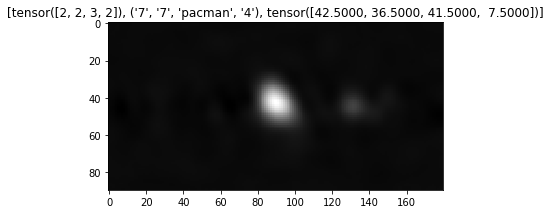

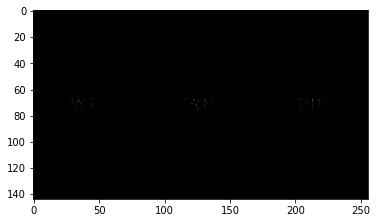

<Figure size 432x288 with 0 Axes>

In [70]:

sal_test_filepath = './data/pano-saliency/ds_dcnn_test'
#sal_ds_filepath = './dataset/pano-saliency/ds_full'
tf5 =  transform.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
test_transformed_dataset = PanoSalDataset(sal_test_filepath, transform=tv.transforms.Compose([tv.transforms.ToTensor(), tf5]))
testloader = t.utils.data.DataLoader(test_transformed_dataset, batch_size=4, shuffle=True, num_workers=4)

with t.no_grad():
    for i, (t0, img_list, label_list) in enumerate(testloader):
        for idx in range(4):
            img_list = img_list.type(t.FloatTensor).to(device)
            fx = resnet(img_list).view(-1, header_sal.TARGET_SAL_H, header_sal.TARGET_SAL_W)
            smap = fx[idx].data.cpu().numpy()
            
            img = img_list[idx].data.cpu().numpy().transpose(1, 2, 0).astype(int)
            label = label_list[idx].data.cpu().numpy()
            plt.imshow(label, cmap='gray')
            plt.figure()
            plt.imshow(smap, cmap='gray')
            plt.title(t0)
            plt.figure()    
            plt.imshow(img)
            plt.figure()
        break

197


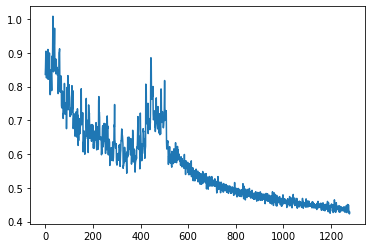

In [57]:
print (epoch)
plt.plot(loss_log[100:])
t.save(resnet.state_dict(), './models/panoresnet152_sal45x80_step002_{}'.format(epoch))

891


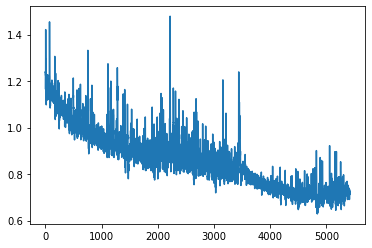

In [20]:
1+1

2

In [41]:
#STEP2: from the model, generate saliency map for all video
#get all timestamp for all saliency_ds{}_topic{}
#generate saliency for given timestamp
#save as named saliency_ds{}_topic_{} in the pano-saliency-predicted folder

In [4]:
#prepare test data to test model
sal_ds_filepath = './dataset/pano-saliency/ds_dcnn_test'
tf5 =  transform.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
transformed_dataset = PanoSalDataset(sal_ds_filepath, transform=tv.transforms.Compose([tv.transforms.ToTensor(), tf5]))
testloader = t.utils.data.DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=4)


In [2]:
#TODO: create saliency data for resnet 101
#load & test model
#PATH = './models/panoresnet152_step003_585'
#PATH = './models/panoresnet101_step005_810'
PATH = './models/panoresnet152_step002_891'
resnet = tv.models.resnet152(pretrained=True)
modify_fc_layers(resnet)
resnet.to(device)
resnet.load_state_dict(t.load(PATH, map_location=device))

<All keys matched successfully>

In [63]:
with t.no_grad():
    for i, (t0, img_list, label_list) in enumerate(testloader):
        for idx in range(4):
            img_list = img_list.type(t.FloatTensor).to(device)
            fx = resnet(img_list).view(-1, header_sal.TARGET_SAL_H, header_sal.TARGET_SAL_W)
            smap = fx[idx].data.cpu().numpy()
            #smap = cv2.resize(smap, (header.TARGET_STANDARD_SAL_W, header.TARGET_STANDARD_SAL_H))
            img = img_list[idx].data.cpu().numpy().transpose(1, 2, 0).astype(int)
            label = label_list[idx].data.cpu().numpy()
            plt.imshow(label, cmap='gray')
            plt.axis('off')
            plt.figure()
            
            plt.imshow(smap, cmap='gray')
            plt.axis('off')
            plt.figure()

            plt.imshow(img)
            plt.title(t0)
            plt.axis('off')
            plt.figure()
        break

NameError: name 'cv2' is not defined

In [ ]:
#TODO: load the ds_full file, makes all prediction, write back into file

In [28]:
pwd

'/home/anh2/workspace/PanoSaliencyModel'

In [49]:
dat = pickle.load(open('./data/pano-saliency/ds_full', 'rb'))


In [55]:
#TODO: Predict salency for ALL image from ALL videos
#input: file ds_full, containing the groundtruth saliency & the images
#output: a dict containting timestmap & predicted saliency for ALL videos

tdict = header.topic_dict
tf_list = tv.transforms.Compose([tv.transforms.ToTensor(), tf5])
salpred_dict = {1:{}, 2:{}, 3:{}}
with t.no_grad():
    for (ds, topic, t0), img, smap in dat:
            #print (f'creating saliency_ds{ds}_topic{topic}')
            x = tf_list(img).unsqueeze(0).to(device)
            fx = resnet(x)
            fx = fx.data.cpu().view(header_sal.TARGET_SAL_H, header_sal.TARGET_SAL_W).numpy()
            #fx = cv2.resize(fx, (header.TARGET_STANDARD_SAL_W, header.TARGET_STANDARD_SAL_H))
            if topic not in salpred_dict[ds]:
                salpred_dict[ds][topic] = []
            salpred_dict[ds][topic].append((t0, -1, fx))
#             plt.imshow(fx.data.cpu().view(H_SAL, W_SAL))
#             plt.figure()
#             plt.imshow(img)
#             plt.title(f'{ds}-{topic}-{t0}')
#             plt.figure()
#             plt.imshow(smap, cmap='gray')
#             plt.figure()


KeyboardInterrupt: 

In [ ]:
#now, write down the predicted saliency into files
#panoresnet101_step005_810
for ds in tdict:
    for topic in tdict[ds]:
        print (f'Writting predicted saliency for ds:{ds} - topic:{topic} to file')
        filepath_name = f'./data/pano-saliency-45x80-pred152-step002-iter197/saliency_ds{ds}_topic{topic}'
        pickle.dump(salpred_dict[ds][topic], open(filepath_name, 'wb'))

In [54]:
1+1

2